# Загрузка дополнительных библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Используемые функции

## 1. Фильтрация для получения целевой КФ заданной в function

In [2]:
def corr_filter(Z, rL_us, corr_us, function):
    signal_length = Z.shape[1]
    x = np.linspace(-rL_us/2,rL_us/2,signal_length)
    f = function(x, corr_us)                        # целевая корреляционная функция
    F = np.sqrt(np.fft.fft(f,signal_length))        # АЧХ фильтра
    F = F/np.max(np.abs(F))                         # нормировка АЧХ на максимальное значение: гармоники не должны училиваться
    f = np.real(np.sqrt(2)*np.fft.ifft(np.fft.fft(Z, signal_length) * F, signal_length))
    return f

## 2. Целевые КФ указанные в задании

In [3]:
def corr_function(x, corr_us):        # КФ указанная в примере
    f = np.exp( -abs(x)/(corr_us/2) )
    return f

def corr_function_1(x, corr_us):
    f = np.exp( -(x/corr_us)**2 )
    return f

def corr_function_2(x, corr_us):
    f = (abs(x) < corr_us) * (1-abs(x)/corr_us)
    return f

def corr_function_3(x, corr_us):
    f = np.cos( 10*x/corr_us )*np.exp( (-1/2) * (x/corr_us)**2 )
    return f

def corr_function_4(x, corr_us):
    f = 1 / ( 1 + (x/corr_us)**2 )
    return f

## 3. Расчёт усреднённой КФ коррелированного СП и КФ входных реализаций 

In [4]:
def calculate_corr_function(n_counts, n_samples, non_corr_process, corr_process):
    
    ry_est = np.zeros((n_counts, 2*n_samples-1))
    rx_est = np.zeros((n_counts, 2*n_samples-1))
    
    # Построчный расчёт корреляции
    for i in range(n_counts):          
        ry_est[i,:] = np.correlate(corr_process[i,:], corr_process[i,:], mode='full')/np.var(corr_process[i,:])\
        / n_samples # КФ
        rx_est[i,:] = np.correlate(non_corr_process[i,:], non_corr_process[i,:], mode='full')/np.var(non_corr_process[i,:])\
        / n_samples # КФ

    # КФ одной коррелированной шумовой рализации
    ry_sample = ry_est[1,:]   
    
    # КФ одной некор шумовой рализации
    rx_sample = rx_est[1,:]
    
    # усреднение КФ некоррелированного СП по множеству реализаций
    rx_est = np.mean(rx_est, axis=0) 
    
    # усреднение КФ коррелированного СП по множеству реализаций
    ry_est = np.mean(ry_est, axis=0)     
    
    return [rx_sample, ry_sample, rx_est, ry_est]

## 4. Построение графических зависимостей

In [5]:
def plot_corr_function(corr_int_us, t_axis, x_exp, y_exp, shift_axis_us, rx_sample_exp, ry_sample_exp, r_est_exp, r_fun_exp):

    plt.figure(figsize = (13, 6), constrained_layout = True)

    # Одна реализация
    #------------------------------------------------------------------------------
    plt.subplot(221)                                    
    plt.plot(t_axis, x_exp[1,:], t_axis, y_exp[1,:])
    plt.xlim(0, 10*corr_int_us)
    plt.title('Одна реализация СП')
    plt.legend(('исходный','коррелированный процесс'))
    plt.xlabel('t'), plt.ylabel('U(t)', rotation='horizontal')
    plt.grid(1)
    # КФ одной реализации
    #------------------------------------------------------------------------------
    plt.subplot(222)                                    
    plt.plot(shift_axis_us, rx_sample_exp, shift_axis_us, ry_sample_exp)
    plt.xlim(-3*corr_int_us, 3*corr_int_us)
    plt.title('КФ одной реализации')
    plt.legend(('исходный','коррелированный процесс'))
    plt.xlabel(r'$\tau$'), plt.ylabel(r'R($\tau$)', rotation='horizontal')
    plt.grid(1)
    # Усреднённая КФ
    #------------------------------------------------------------------------------
    plt.subplot(2,2,(3,4))                              
    plt.plot(shift_axis_us, r_est_exp, shift_axis_us, r_fun_exp)
    plt.xlim(-3*corr_int_us, 3*corr_int_us)
    plt.title('КФ')
    plt.legend(('моделирование','аналитически заданная'))
    plt.xlabel(r'$\tau$'), plt.ylabel(r'R($\tau$)', rotation='horizontal');
    plt.grid(1)
    plt.show()

In [6]:
def plot_four_corr_function(corr_int_us, shift_axis_us, r_est, r_fun, r_est_1, r_fun_1, r_input_est):
    plt.figure(figsize = (13, 6), constrained_layout = True)
                             
    plt.plot(shift_axis_us, r_est, shift_axis_us, r_fun, shift_axis_us, r_est_1, shift_axis_us, r_fun_1)
    plt.plot(shift_axis_us, r_input_est)
    plt.xlim(-3*corr_int_us, 3*corr_int_us)
    plt.title('КФ')
    plt.legend(('моделирование (l)','аналитически заданная (l)', 'моделирование (2*l)','аналитически заданная (2*l)'\
                , 'усреднённая КФ входного СП'))
    plt.xlabel(r'$\tau$'), plt.ylabel(r'R($\tau$)', rotation='horizontal');
    plt.grid(1)
    plt.show()

In [7]:
def plot_hist_distribution(mu_param, sigma_normal, x_hist, y_hist):
    n_edges = 50          # количество бинов в гистограмме 
    x_axis = np.linspace(-3*sigma_normal + mu_param, 3*sigma_normal + mu_param, n_edges)
    w_analityc = norm.pdf(x_axis, loc = mu_param, scale = sigma_normal) # аналитическое значение СВ
    
    plt.figure(figsize = (13, 6), constrained_layout = True)
    plt.plot(x_axis, w_analityc, 'g-', label = 'аналитическая ' + 'm = ' + str(mu_param) + ', sigma = ' + str(sigma_normal))
    plt.hist([x_hist.flatten(), y_hist.flatten()], bins=x_axis, density=True, label = ['входной СП', 'выходной СП'])
    plt.legend(loc='best', frameon=False)
    plt.title('Гистограммы распределения отсчётов СП по всем реализациям на входе и выходе фильтра') 
    plt.xlabel('y')
    plt.ylabel('W(y)', rotation='horizontal')
    plt.grid(1)
    plt.show() # m=' + str(mu_param) + ', sigma= ' + str(sigma_param)

In [8]:
def plot_SDP(rx_est, ry_est):
    
    sy = np.fft.fft(ry_est, norm = 'forward')
    sx = np.fft.fft(rx_est, norm = 'forward')
    sy = np.abs(np.fft.fftshift(sy))
    sx = np.abs(np.fft.fftshift(sx))
    
    f_s = np.linspace(-0.5*f_sampling_mhz , 0.5*f_sampling_mhz, len(ry_est))
    
    plt.figure(figsize = (13, 6), constrained_layout = True)
    
    plt.subplot(221)   
    plt.plot(f_s, sx)
    plt.xlim(-0.5*f_sampling_mhz/8, 0.5*f_sampling_mhz/8)
    plt.title('СПМ')
    plt.xlabel('f'), plt.ylabel(r'S($\omega$)', rotation='horizontal')
    plt.grid(1)
    
    plt.subplot(222)   
    plt.plot(f_s, sy)
    plt.xlim(-0.5*f_sampling_mhz/8, 0.5*f_sampling_mhz/8)
    plt.title('СПМ')
    plt.xlabel('f'), plt.ylabel(r'S($\omega$)', rotation='horizontal')
    plt.grid(1)

# Выполние моделирования СП с заданной КФ

## 1. Параметры моделирования и распределения

In [9]:
time_window_us = 300            # временной интервал на котором рассматривается корреляция, мкс
f_sampling_mhz = 20             # частота дискретизации, МГц
sigma_normal = 11               # СКО гауссовского случайного процесса
mu_param = 0                    # мат ожидание исходного процесса
corr_int_us = 2                 # интеравал корреляции, мкс
corr_int_us_2 = 2 * corr_int_us # интервал корреляции увеличенный вдвое, мкс 
n_counts = 20                   # число усредняемых реализаций
n_samples = int(time_window_us*f_sampling_mhz); # число отсчетов

## 2. Моделирование СП с экспоненциальной КФ

In [10]:
x_exp = np.random.normal(mu_param, sigma_normal, (n_counts, n_samples))     # исходный СП
y_exp = corr_filter(x_exp, time_window_us, corr_int_us, corr_function)      # коррелированный СП

# Расчёт КФ
[rx_sample_exp, ry_sample_exp, rx_est_exp, ry_est_exp] = calculate_corr_function(n_counts, n_samples, x_exp, y_exp)

t_axis = np.linspace(0, time_window_us, n_samples)                          # ось времени реализации сигнала
shift_axis_us = np.linspace(-time_window_us, time_window_us, 2*n_samples-1)  # ось отстройки КФ

r_fun_exp = corr_function(shift_axis_us, corr_int_us)    # аналитически заданная КФ

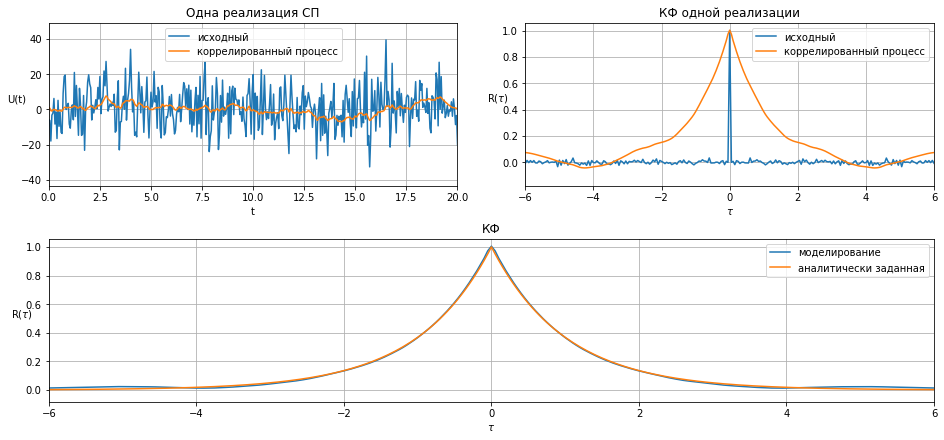

In [11]:
plot_corr_function(corr_int_us, t_axis, x_exp, y_exp, shift_axis_us, rx_sample_exp, ry_sample_exp, ry_est_exp, r_fun_exp)

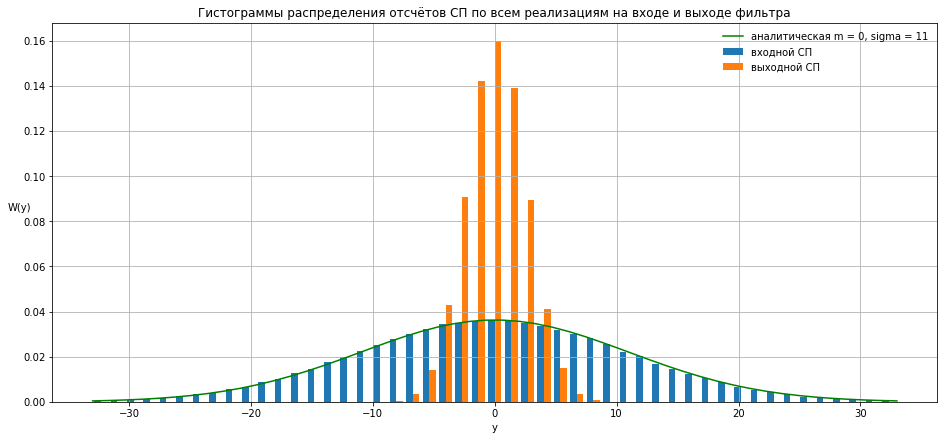

In [12]:
plot_hist_distribution(mu_param, sigma_normal, x_exp, y_exp)

## 3. Моделирование СП с КФ заданной function_1

In [19]:
x_1 = np.random.normal(mu_param, sigma_normal, (n_counts, n_samples))     # исходный СП
y_1 = corr_filter(x_1, time_window_us, corr_int_us, corr_function_1)      # коррелированный СП
y_1_2 = corr_filter(x_1, time_window_us, corr_int_us_2, corr_function_1)  # коррелированный СП с удвоенным corr_int

# Расчёт КФ
[rx_sample_1, ry_sample_1, rx_est_1, ry_est_1] = calculate_corr_function(n_counts, n_samples, x_1, y_1)
[rx_sample_1_2, ry_sample_1_2, rx_est_1_2, ry_est_1_2] = calculate_corr_function(n_counts, n_samples, x_1, y_1_2)

t_axis = np.linspace(0, time_window_us, n_samples)                           # ось времени реализации сигнала
shift_axis_us = np.linspace(-time_window_us, time_window_us, 2*n_samples-1)  # ось отстройки КФ

r_fun_1 = corr_function_1(shift_axis_us, corr_int_us)        # аналитически заданная КФ
r_fun_1_2 = corr_function_1(shift_axis_us, corr_int_us_2)    # аналитически заданная КФ с удвоенным corr_int

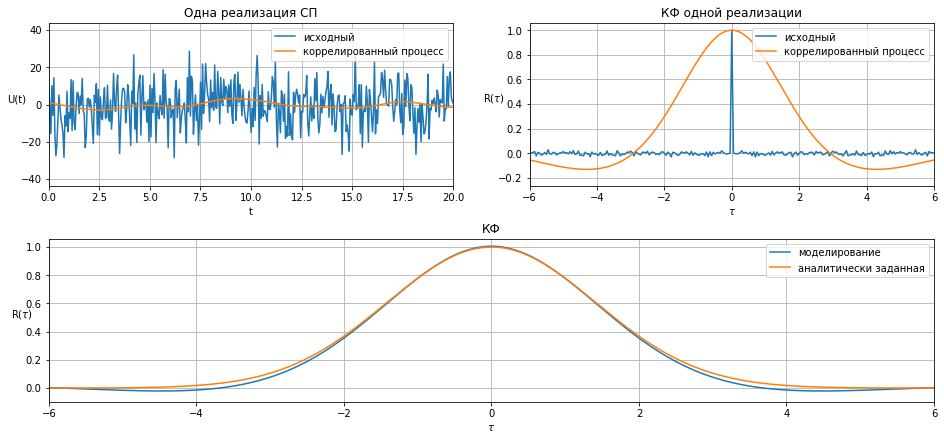

In [20]:
# Построение КФ коррелированной и некоррелированной реализации, КФ смоделированного СП и аналитически заданную КФ
plot_corr_function(corr_int_us, t_axis, x_1, y_1, shift_axis_us, rx_sample_1, ry_sample_1, ry_est_1, r_fun_1)

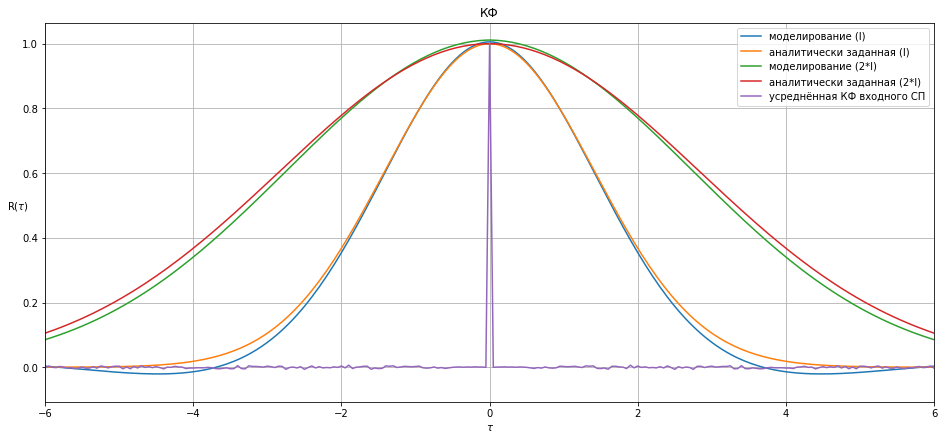

In [21]:
# Сравнение усреднённых КФ для разных интервалов корреляции 
plot_four_corr_function(corr_int_us, shift_axis_us, ry_est_1, r_fun_1, ry_est_1_2, r_fun_1_2, rx_est_1)

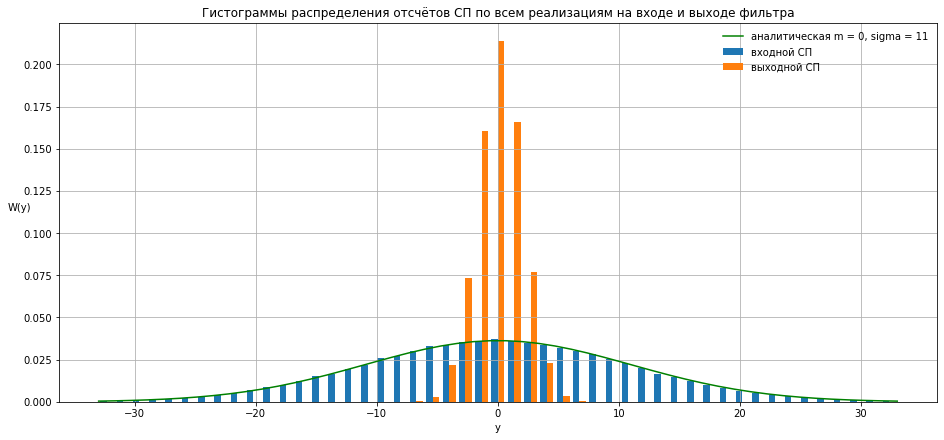

In [22]:
# Построение гистограмм распределения
plot_hist_distribution(mu_param, sigma_normal, x_1, y_1)

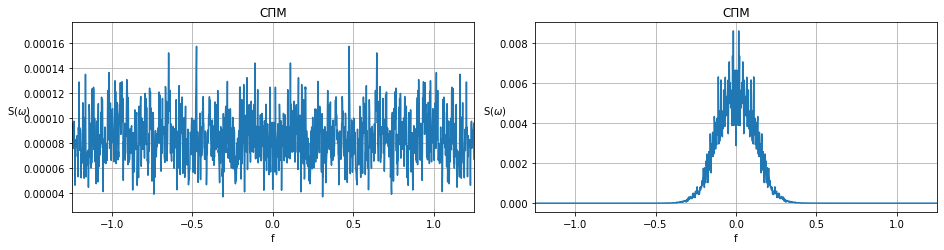

In [23]:
plot_SDP(rx_est_1, ry_est_1)

## 4. Моделирование СП с КФ заданной function_2

In [24]:
x_2 = np.random.normal(mu_param, sigma_normal, (n_counts, n_samples))     # исходный СП
y_2 = corr_filter(x_2, time_window_us, corr_int_us, corr_function_2)      # коррелированный СП
y_2_2 = corr_filter(x_2, time_window_us, corr_int_us_2, corr_function_2)  # коррелированный СП с удвоенным corr_int

# Расчёт КФ
[rx_sample_2, ry_sample_2, rx_est_2, ry_est_2] = calculate_corr_function(n_counts, n_samples, x_2, y_2)
[rx_sample_2_2, ry_sample_2_2, rx_est_2_2, ry_est_2_2] = calculate_corr_function(n_counts, n_samples, x_2, y_2_2)

t_axis = np.linspace(0, time_window_us, n_samples)                           # ось времени реализации сигнала
shift_axis_us = np.linspace(-time_window_us, time_window_us, 2*n_samples-1)  # ось отстройки КФ

r_fun_2 = corr_function_2(shift_axis_us, corr_int_us)        # аналитически заданная КФ
r_fun_2_2 = corr_function_2(shift_axis_us, corr_int_us_2)    # аналитически заданная КФ с удвоенным corr_int

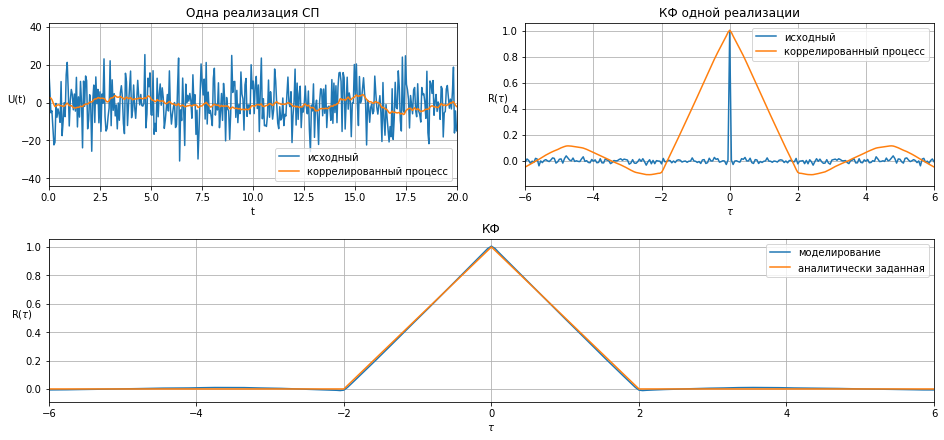

In [25]:
# Построение КФ коррелированной и некоррелированной реализации, КФ смоделированного СП и аналитически заданную КФ
plot_corr_function(corr_int_us, t_axis, x_2, y_2, shift_axis_us, rx_sample_2, ry_sample_2, ry_est_2, r_fun_2)

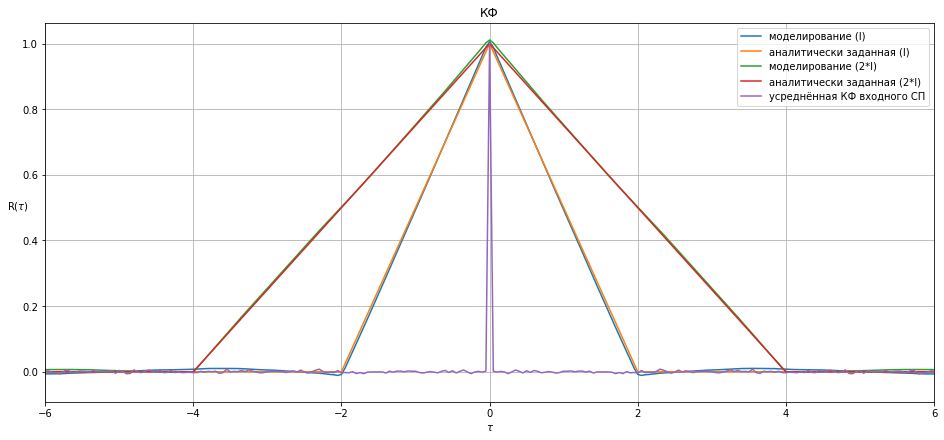

In [26]:
# Сравнение усреднённых КФ для разных интервалов корреляции 
plot_four_corr_function(corr_int_us, shift_axis_us, ry_est_2, r_fun_2, ry_est_2_2, r_fun_2_2, rx_est_2)

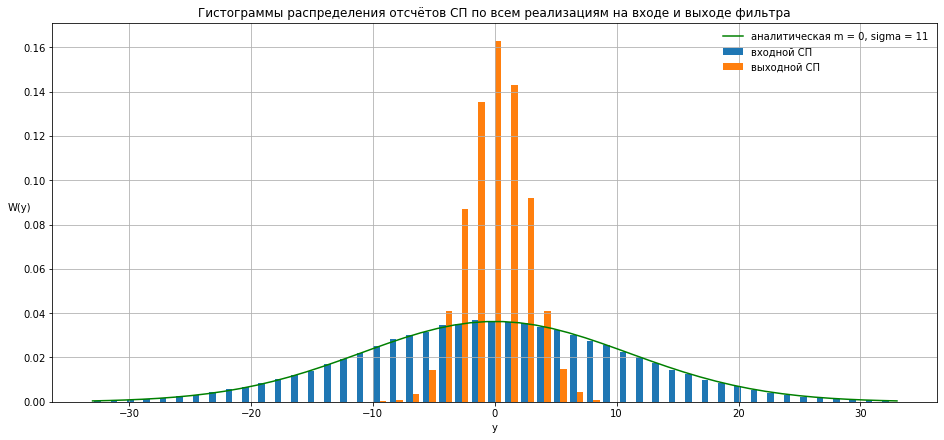

In [27]:
# Построение гистограмм распределения
plot_hist_distribution(mu_param, sigma_normal, x_2, y_2)

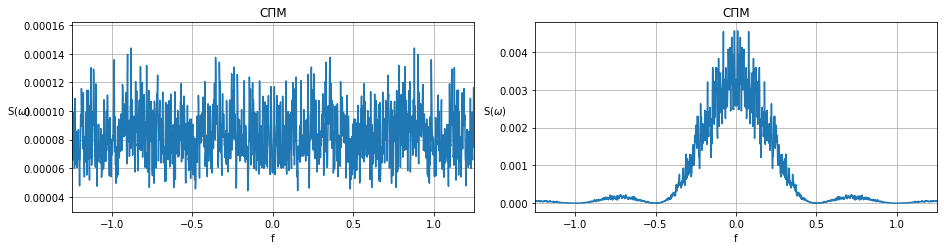

In [28]:
plot_SDP(rx_est_2, ry_est_2)

## 5. Моделирование СП с КФ заданной function_3

In [29]:
x_3 = np.random.normal(mu_param, sigma_normal, (n_counts, n_samples))     # исходный СП
y_3 = corr_filter(x_3, time_window_us, corr_int_us, corr_function_3)      # коррелированный СП
y_3_2 = corr_filter(x_3, time_window_us, corr_int_us_2, corr_function_3)  # коррелированный СП с удвоенным corr_int

# Расчёт КФ
[rx_sample_3, ry_sample_3, rx_est_3, ry_est_3] = calculate_corr_function(n_counts, n_samples, x_3, y_3)
[rx_sample_3_2, ry_sample_3_2, rx_est_3_2, ry_est_3_2] = calculate_corr_function(n_counts, n_samples, x_3, y_3_2)

t_axis = np.linspace(0, time_window_us, n_samples)                           # ось времени реализации сигнала
shift_axis_us = np.linspace(-time_window_us, time_window_us, 2*n_samples-1)  # ось отстройки КФ

r_fun_3 = corr_function_3(shift_axis_us, corr_int_us)        # аналитически заданная КФ
r_fun_3_2 = corr_function_3(shift_axis_us, corr_int_us_2)    # аналитически заданная КФ с удвоенным corr_int

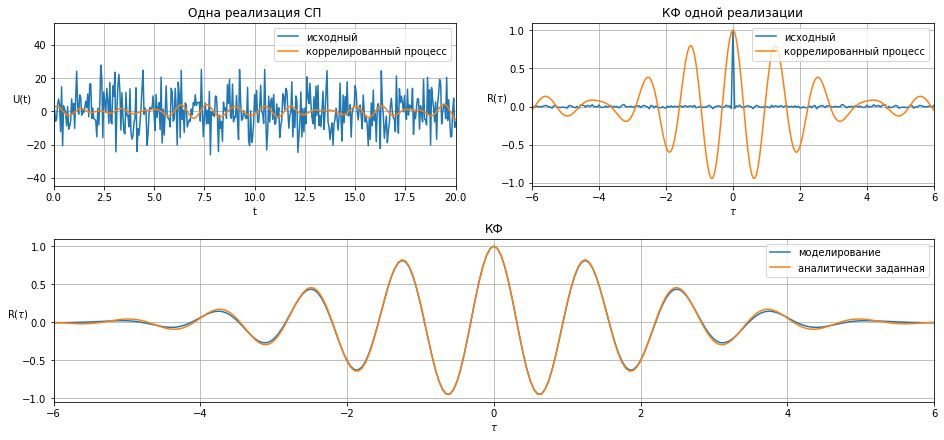

In [30]:
# Построение КФ коррелированной и некоррелированной реализации, КФ смоделированного СП и аналитически заданную КФ
plot_corr_function(corr_int_us, t_axis, x_3, y_3, shift_axis_us, rx_sample_3, ry_sample_3, ry_est_3, r_fun_3)

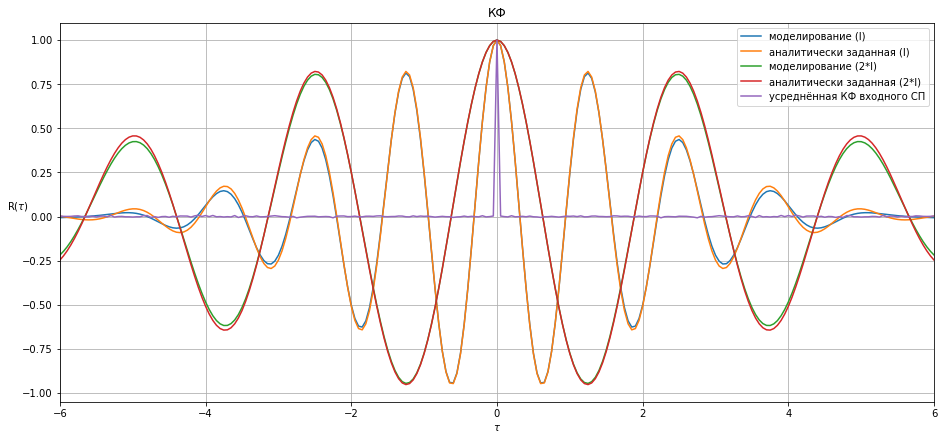

In [31]:
# Сравнение усреднённых КФ для разных интервалов корреляции 
plot_four_corr_function(corr_int_us, shift_axis_us, ry_est_3, r_fun_3, ry_est_3_2, r_fun_3_2, rx_est_3)

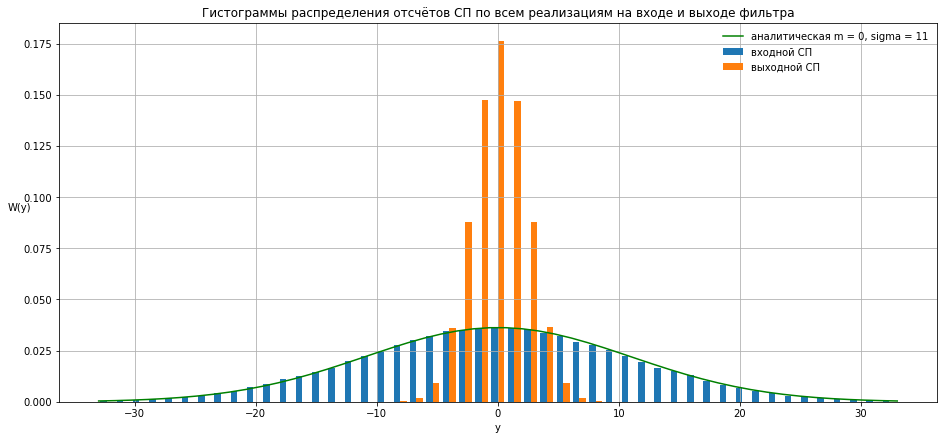

In [32]:
# Построение гистограмм распределения
plot_hist_distribution(mu_param, sigma_normal, x_3, y_3)

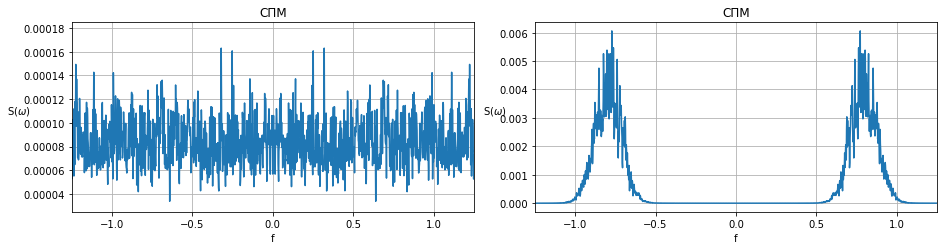

In [33]:
plot_SDP(rx_est_3, ry_est_3)

## 6. Моделирование СП с КФ заданной function_4

In [52]:
x_4 = np.random.normal(mu_param, sigma_normal, (n_counts, n_samples))     # исходный СП
y_4 = corr_filter(x_4, time_window_us, corr_int_us, corr_function_4)      # коррелированный СП
y_4_2 = corr_filter(x_4, time_window_us, corr_int_us_2, corr_function_4)  # коррелированный СП с удвоенным corr_int

# Расчёт КФ
[rx_sample_4, ry_sample_4, rx_est_4, ry_est_4] = calculate_corr_function(n_counts, n_samples, x_4, y_4)
[rx_sample_4_2, ry_sample_4_2, rx_est_4_2, ry_est_4_2] = calculate_corr_function(n_counts, n_samples, x_4, y_4_2)

t_axis = np.linspace(0, time_window_us, n_samples)                           # ось времени реализации сигнала
shift_axis_us = np.linspace(-time_window_us, time_window_us, 2*n_samples-1)  # ось отстройки КФ

r_fun_4 = corr_function_4(shift_axis_us, corr_int_us)        # аналитически заданная КФ
r_fun_4_2 = corr_function_4(shift_axis_us, corr_int_us_2)    # аналитически заданная КФ с удвоенным corr_int

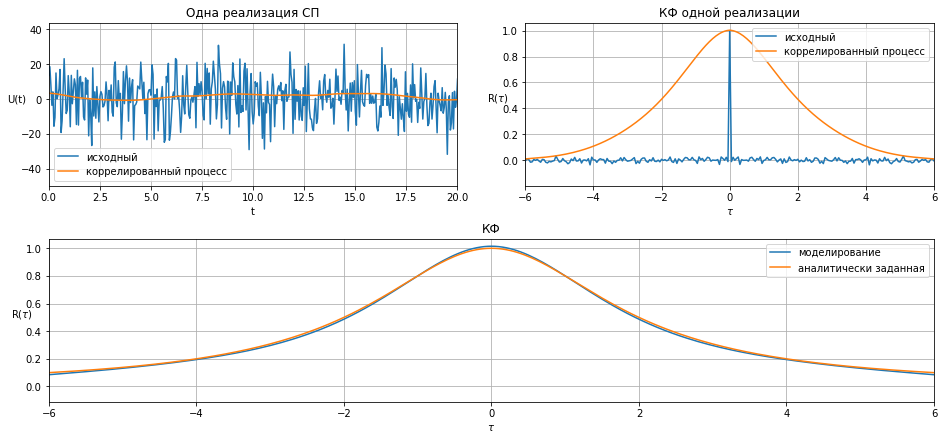

In [53]:
# Построение КФ коррелированной и некоррелированной реализации, КФ смоделированного СП и аналитически заданную КФ
plot_corr_function(corr_int_us, t_axis, x_4, y_4, shift_axis_us, rx_sample_4, ry_sample_4, ry_est_4, r_fun_4)

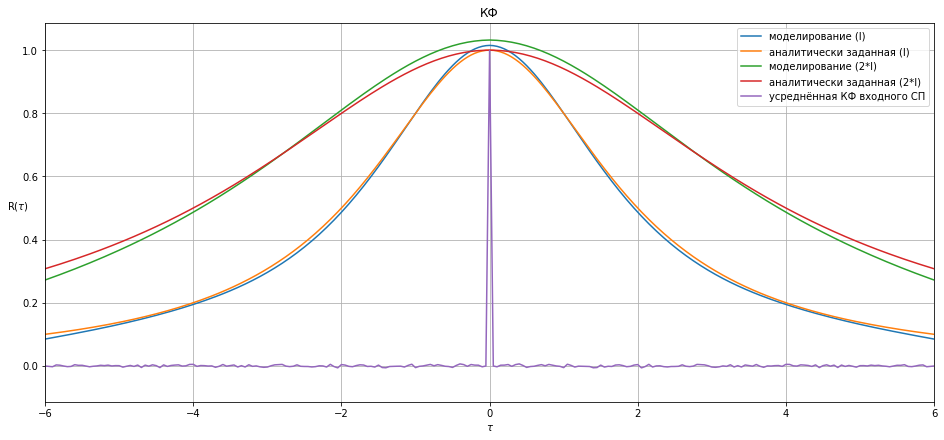

In [54]:
# Сравнение усреднённых КФ для разных интервалов корреляции 
plot_four_corr_function(corr_int_us, shift_axis_us, ry_est_4, r_fun_4, ry_est_4_2, r_fun_4_2, rx_est_4)

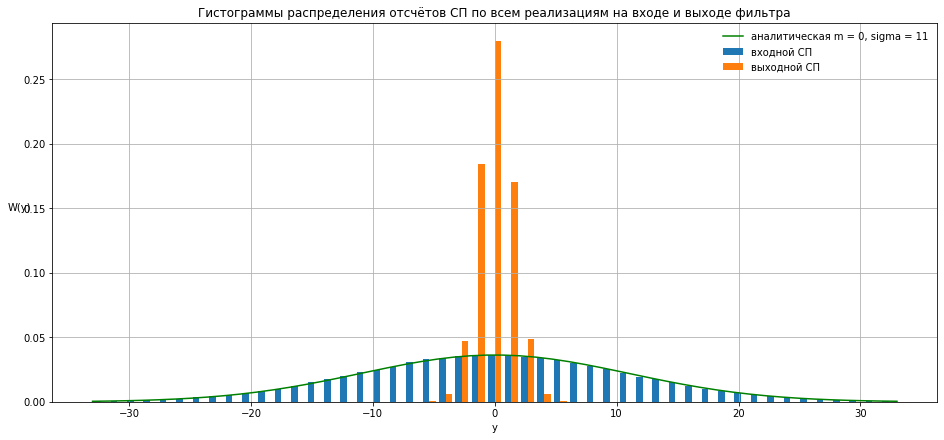

In [55]:
# Построение гистограмм распределения
plot_hist_distribution(mu_param, sigma_normal, x_4, y_4)

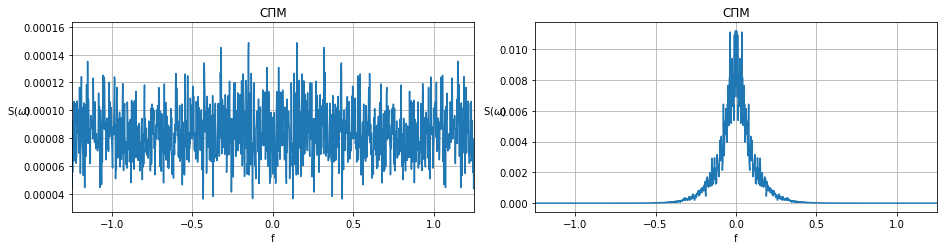

In [56]:
plot_SDP(rx_est_4, ry_est_4)